<a href="https://colab.research.google.com/github/kasprova/advanced_customer_analytics/blob/master/notebooks/clusterisation_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CLUSTERIZATION: pyspark - ML

In [1]:
!nvidia-smi

Sat Oct 26 03:32:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf
conf = SparkConf().setAppName("App")
conf = (conf.set('spark.driver.memory', '11G'))

sc = pyspark.SparkContext(conf=conf)
from pyspark.sql import SQLContext
sql = SQLContext(sc)

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from functools import reduce
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
plt.style.use('ggplot')
#plt.style.use('default')
plt.rcParams["figure.figsize"] = (10,5)

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

### Load Data

In [7]:
#mount google drive to get access to the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip -q "drive/My Drive/analytics/universal_features_manual_cat_191020_.zip"
#universal_features = "content/universal_features_manual_cat_191020_.parquet"

In [0]:
!unzip -q "drive/My Drive/analytics/scaled_df_kmeans_201509_201608.zip"

In [19]:
%ls content/scaled_df_kmeans.parquet

scaled_df_kmeans.parquet


In [0]:
scaled_data_kmeans = "content/scaled_df_kmeans.parquet"
df = spark.read.parquet(scaled_data_kmeans)

In [21]:
df.columns

['monetary',
 'discount_number__total',
 'cat_m_prepared_food_paid_amount_pcnt',
 'frequency',
 'recency',
 'cat_m_proteins_paid_amount_pcnt',
 'cat_m_diary_paid_amount_pcnt',
 'cat_m_sause_paid_amount_pcnt',
 'cat_m_misc_paid_amount_pcnt',
 'cat_m_greens_paid_amount_pcnt',
 'cat_m_drinks_paid_amount_pcnt',
 'discount_number__xxx_credit',
 'discount_value__total',
 'duration_since_start__months',
 'cat_m_grains_paid_amount_pcnt',
 'discount_value__xxx_credit',
 'deposite_number__bottle',
 'cat_m_baking_paid_amount_pcnt',
 'cat_m_sweets_paid_amount_pcnt',
 'deposite_value__bottle',
 'cards_number',
 'cat_m_baby_and_pets_paid_amount_pcnt',
 'cat_m_alco_tabacco_paid_amount_pcnt',
 'churn',
 'discount_value__manufacture_coupon',
 'discount_number__manufacture_coupon']

In [0]:
# Create a vector representation for features
assembler = VectorAssembler(inputCols = df.columns,
                            outputCol = "features")
train_df = assembler.transform(df)

In [24]:
#check
kmeans = KMeans(k=2, seed=1) 
model = kmeans.fit(train_df.select('features'))

transformed = model.transform(train_df)
transformed.show()

+--------------------+----------------------+------------------------------------+--------------------+--------------------+-------------------------------+----------------------------+----------------------------+---------------------------+-----------------------------+-----------------------------+---------------------------+---------------------+----------------------------+-----------------------------+--------------------------+-----------------------+-----------------------------+-----------------------------+----------------------+-------------------+------------------------------------+-----------------------------------+--------------------+----------------------------------+-----------------------------------+--------------------+----------+
|            monetary|discount_number__total|cat_m_prepared_food_paid_amount_pcnt|           frequency|             recency|cat_m_proteins_paid_amount_pcnt|cat_m_diary_paid_amount_pcnt|cat_m_sause_paid_amount_pcnt|cat_m_misc_paid_amount_

In [0]:
for i in range(2,100):
    kmeans = KMeans(k=i, seed=42) 
    model = kmeans.fit(train_df.select('features'))
    cost = model.computeCost(train_df)
    
    # Make predictions
    predictions = model.transform(train_df)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print(i, cost, silhouette_score)

    # Shows the result.
    #centers = model.clusterCenters()
    #print("Cluster Centers: ")
    #for center in centers:
    #    print(center)

In [0]:
data = np.array([[2, 34108285.45395221, 0.35623675817434414],
[3, 33068428.697895456, 0.23247222523550898],
[4, 31372970.29455901, 0.06518590836296437],
[5, 30374156.7988558, 0.10812559178358663],
[6, 29339304.771187697, 0.11384034752106144],
[7, 28481000.02717915, 0.13601242755452267],
[8, 27806865.934101358, 0.10538060582522213],
[9, 26655544.668956067, 0.14256804458454952],
[10, 25876526.99388953, 0.1433157801654074],
[11, 24903831.52747007, 0.16784070188436861],
[12, 24240707.38244125, 0.16977420351262487],
[13, 23226966.402522348, 0.15683724942779492],
[14, 21935341.085451957, 0.18629750510675602],
[15, 21463247.006589293, 0.20951803507589079],
[16, 20340992.64433414, 0.2099820589879696],
[17, 20152829.317581665, 0.21237819656809903],
[18, 19470092.649169605, 0.18273363309229562],
[19, 18786899.17408782, 0.20472374733972118],
[20, 18355552.880109232, 0.1987905659565371],
[21, 17505375.470361996, 0.21073589585849342],
[22, 18108457.53648358, 0.1943716980359304],
[23, 17170931.94309841, 0.20141946326734028],
[24, 16624961.729605021, 0.21432294092634727],
[25, 16545067.399060573, 0.21495574270871645],
[26, 16514694.416570978, 0.19398607011228755],
[27, 15943873.381710406, 0.19388345694016565],
[28, 15758852.047461867, 0.2043457894516444],
[29, 16084365.599573346, 0.19853023578572182],
[30, 15449843.352047468, 0.20322709035733225],
[31, 15199240.822174236, 0.20789632713620476],
[32, 15122123.406696528, 0.20869966477409393],
[33, 14833293.894855892, 0.1957556718180235],
[34, 14871855.88415188, 0.20015649407226555],
[35, 14974888.901705408, 0.1852417588279316],
[36, 14543368.034821356, 0.21169611116436524],
[37, 14576541.065633526, 0.18573879391434964],
[38, 14474352.469131252, 0.18956600221202882],
[39, 14255825.300158285, 0.1788115689044209],
[40, 14137271.377735797, 0.18948182294696958],
[41, 13963702.583961226, 0.18213406902765858],
[42, 13730271.460833658, 0.195304768352631],
[43, 13686708.396873973, 0.19578940327578817],
[44, 13619843.654508471, 0.18420219258229867],
[45, 13511111.189698363, 0.19573093930302393],
[46, 13290273.62608452, 0.1902547306043693],
[47, 13289543.325750258, 0.17565761804441074],
[48, 13129006.581908906, 0.18025246971334064],
[49, 13158635.91108229, 0.18405606327756918],
[50, 12909514.878511624, 0.18730782015140862]]
)
df = pd.DataFrame(data, columns = ["num_clusters", "score", "silhouette"])

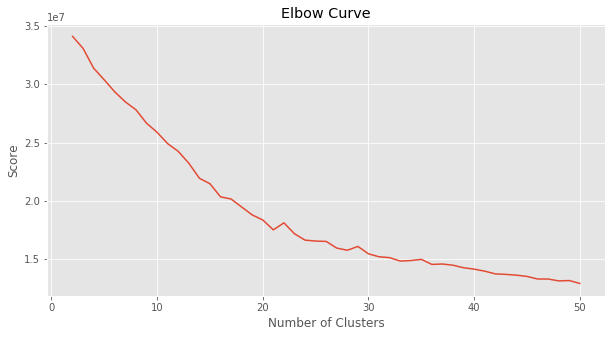

In [37]:
plt.plot(df['num_clusters'], df['score'])
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

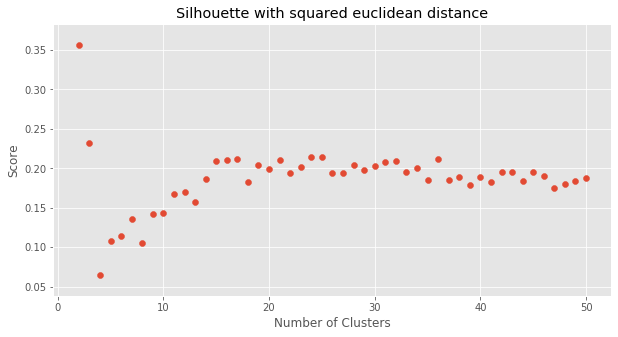

In [38]:
plt.scatter(df['num_clusters'], df['silhouette'])
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette with squared euclidean distance')
plt.show()

In [0]:
#import os
#os.system('say "your program has finished"')

### References:
1. https://stackoverflow.com/questions/47585723/kmeans-clustering-in-pyspark
2. https://spark.apache.org/docs/latest/ml-clustering.html - example silhouette 
3. https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
4. http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=kmeans#pyspark.mllib.clustering.KMeansModel.clusterCenters
5. https://stats.stackexchange.com/questions/135656/k-means-a-k-a-scalable-k-means
6. https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6 
7. https://datascience-enthusiast.com/Python/DBSCAN_Kmeans.html - DBSCAN